# Predicting Carbon based on NDMI, Age, Precipictation, Temperature, and NDVI data

## Importing all the Required packages that we'll use first

In [149]:
import random
import pickle
import time
import pathlib

import pandas as pd
import numpy as np
import rasterio as rio
import tqdm

import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
# import matplotlib.patches as mpatches
# import matplotlib.ticker as mticker
# import matplotlib.font_manager
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split

from yellowbrick.regressor import PredictionError
from sklearn.metrics import r2_score

coreLimit = int(336*(3/4)) # Parallel Processing # 336 Total Cores Available

## Creating a Data Handling Class for ease of passing data around. 

In [150]:
class Data():
    def __init__(self, X=None, Y=None):
        if X != None:
            self.__x = X
        else:
            self.__x = 0
        if Y != None:
            self.__y = Y
        else:
            self.__y = 0

    def __del__(self):
        del self.__x, self.__y

    def set_x(self, X):
        self.__x = X

    def set_y(self, Y):
        self.__y = Y
        
    def get_x(self):
        return self.__x

    def get_y(self):
        return self.__y
# end Data

## Reading Data into Memory

                  id   NDVI_Jun13   NDMI_Jun13    PRISM_ppt   PRISM_tave  \
count    8972.000000  8972.000000  8972.000000  8972.000000  8972.000000   
mean   150365.543134  3718.405818  2573.032835  1844.759106     9.871255   
std     86876.831487  1008.975086  1038.889180   799.263008     1.604917   
min        37.000000   526.500000 -1540.000000   265.000000     4.600000   
25%     76147.750000  3009.875000  2119.950000  1323.450000     9.100000   
50%    150075.000000  3767.000000  2821.800000  1819.000000    10.100000   
75%    225767.750000  4486.625000  3302.025000  2340.000000    10.900000   
max    299930.000000  6254.700000  4616.600000  5057.200000    15.400000   

       Biomass (mg/ha)  Carbon (mg/ha)    Stock (%)      Age2018   Height2018  
count      8972.000000     8972.000000  8972.000000  8972.000000  8972.000000  
mean        207.308783       52.464164    56.094293    64.451772    68.357000  
std          80.398512       33.962980    14.187081    38.416300    22.2509

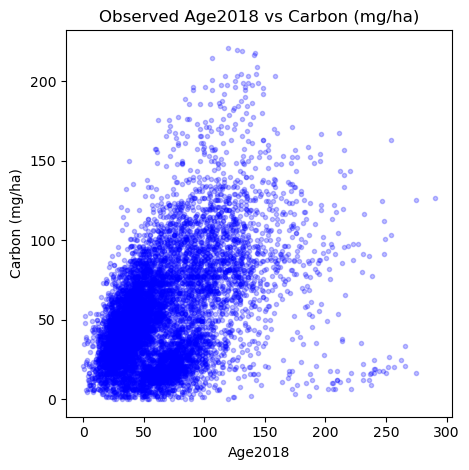

In [151]:
USFS_forest_file = 'data/csv_files/USFS_forest_biomass_mg_ha_Privategt50__CAORWA_Unburned_random_10K.dbf.csv'
USFS_forest = pd.read_csv(USFS_forest_file)

# Removing invalid data (i.e., -9999.0)
count = 0
for i in USFS_forest:
    USFS_forest = USFS_forest[USFS_forest[i] != -9999.0] # Recreating dataset without invalid rows
    if i == 'Age2018' or i == 'biomass_mg':
        USFS_forest = USFS_forest[USFS_forest[i] != 0]
USFS_forest['Carbon2018'] = USFS_forest['Carbon2018']*11.11
USFS_forest = USFS_forest.rename(columns={'Carbon2018': 'Carbon (mg/ha)', 'biomass_mg': 'Biomass (mg/ha)', 'Stock2018': 'Stock (%)'})
print(USFS_forest.describe()) # Post-Removal

# Displaying all the Relevant Data
plot1 = plt.scatter(USFS_forest['Age2018'], USFS_forest['Carbon (mg/ha)'], label = 'Observed', color = 'blue', marker='.', alpha=0.25)
plt.gca().set_aspect(aspect=1/plt.gca().get_data_ratio())
plt.xlabel('Age2018')
plt.ylabel('Carbon (mg/ha)')
plt.title('Observed Age2018 vs Carbon (mg/ha)')
plt.tight_layout()
plt.show()

## Splitting the Data

In [152]:
x_train, x_test , y_train, y_test= train_test_split(
    USFS_forest[[
        'NDVI_Jun13', 
        'NDMI_Jun13', 
        'PRISM_ppt', 
        'PRISM_tave', 
        # 'Carbon (mg/ha)', # Possible Y # Uses Mg C per 30x30 Pixel (Conversion factor: 11.11 for Mg/ha)
        # 'Stock (%)',  # Possible Y
        'Age2018', 
        # 'Height2018', # Possible Y
        # 'Biomass (mg/ha)', # Possible Y
    ]], 
    USFS_forest['Carbon (mg/ha)'],
    train_size=0.8, # 80%, 20% data split. 80% for training and 20% for testing
    shuffle=True, # Default: True
)
model_data = Data() # A container for our data
model_data.set_x([x_train, x_test])
model_data.set_y([y_train, y_test])

## Creating a new Model

In [153]:
pipe = Pipeline([
    ("scale", QuantileTransformer()),
    ("model", RandomForestRegressor()),
])  

model = RandomizedSearchCV(
    estimator=pipe,
    param_distributions={
        'scale__n_quantiles':[i for i in range (10, 1000)], 
        'model__n_estimators': [i for i in range(100, 1000)], 
        'model__max_depth': [i for i in range(1, 2000)],
        'model__max_features':['log2', 'sqrt',]+[i for i in range(1, 1000)],
        'model__min_samples_leaf':[i for i in range (1, 1000)],
        'model__min_samples_split':[i for i in range (2, 1000)],
    },
    refit=True,
    cv=10, # Cross Validations
    n_jobs=coreLimit, # Parallel Processing # 336 Total Cores Available
    verbose=1,
    n_iter=1000, # Number of Iterations (Default: 10)
)
model

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('scale', QuantileTransformer()),
                                             ('model',
                                              RandomForestRegressor())]),
                   n_iter=1000, n_jobs=252,
                   param_distributions={'model__max_depth': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10, 11,
                                                             12, 13, 14, 15, 16,
                                                             17, 18, 19, 20, 21,
                                                             22, 23, 24, 25, 26,
                                                             27, 28, 29, 30, ...],
                                        'model__max_features': ['log2', 'sqrt',
                                                                1, 2, 3, 4, 5,
                                                                6, 7, 8, 9, 10,
                                                                11, 12, 13, 14,
                                                                15, 16, 17, 18...
                                                                     6, 7, 8, 9,
                                                                     10, 11, 12,
                                                                     13, 14, 15,
                                                                     16, 17, 18,
                                                                     19, 20, 21,
                                                                     22, 23, 24,
                                                                     25, 26, 27,
                                                                     28, 29, 30,
                                                                     31, ...],
                                        'model__n_estimators': [100, 101, 102,
                                                                103, 104, 105,
                                                                106, 107, 108,
                                                                109, 110, 111,
                                                                112, 113, 114,
                                                                115, 116, 117,
                                                                118, 119, 120,
                                                                121, 122, 123,
                                                                124, 125, 126,
                                                                127, 128, 129, ...],
                                        'scale__n_quantiles': [10, 11, 12, 13,
                                                               14, 15, 16, 17,
                                                               18, 19, 20, 21,
                                                               22, 23, 24, 25,
                                                               26, 27, 28, 29,
                                                               30, 31, 32, 33,
                                                               34, 35, 36, 37,
                                                               38, 39, ...]},
                   verbose=1)

## Fitting the Model to the Data

In [154]:
timeStart = time.time()
carbon_rf = model.fit(model_data.get_x()[0], model_data.get_y()[0])
print('Fit completed in '+str(round((time.time()-timeStart)//60))+' minutes and '+str(round((time.time()-timeStart)%60, 1))+' seconds.')
results = pd.DataFrame(carbon_rf.cv_results_) # Saving the cross validation results for later

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits
Fit completed in 6 minutes and 29.1 seconds.


## Predicting and Generating Graphs

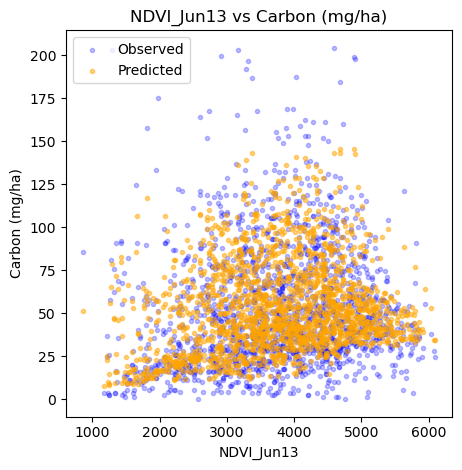

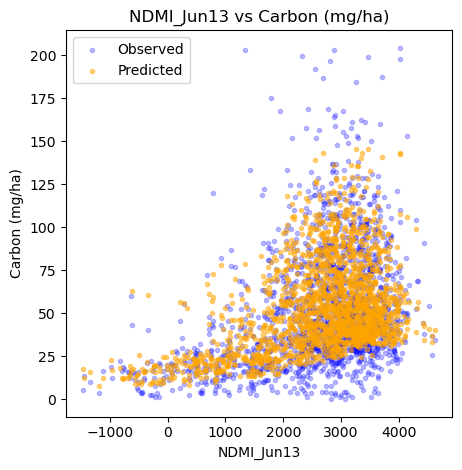

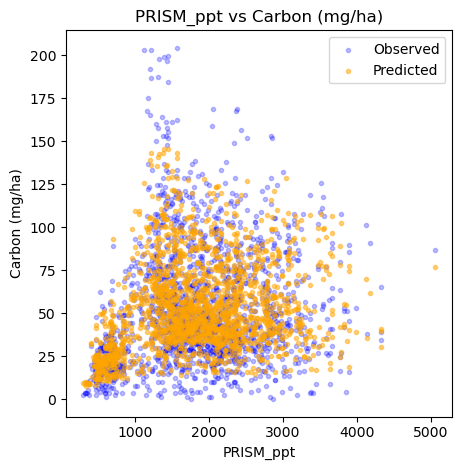

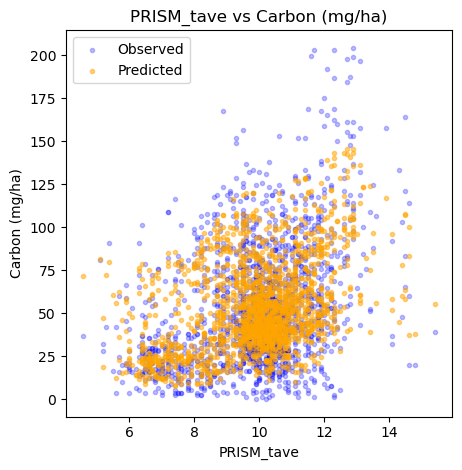

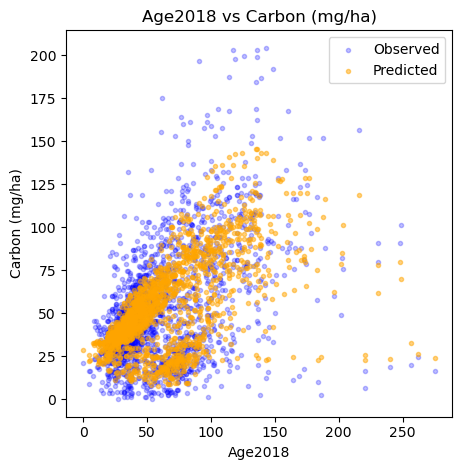

In [155]:
pred = model.predict(model_data.get_x()[1])

for k, v in enumerate(model_data.get_x()[1]):
    plot1 = plt.scatter(model_data.get_x()[1][v], model_data.get_y()[1], label = 'Observed', color = 'blue', marker='.', alpha=0.25)
    plot2 = plt.scatter(model_data.get_x()[1][v], pred, label = 'Predicted', color = 'orange', marker='.', alpha=0.5)
    plt.gca().set_aspect(aspect=1/plt.gca().get_data_ratio()) # Setting the graph(s) to be a one to one ratio (square)
    plt.xlabel(v)
    plt.ylabel('Carbon (mg/ha)')
    plt.title(str(v)+' vs Carbon (mg/ha)')
    plt.legend(handles=[plot1, plot2], loc='best',)
    plt.tight_layout()
    plt.show()

## Visualizing Errors

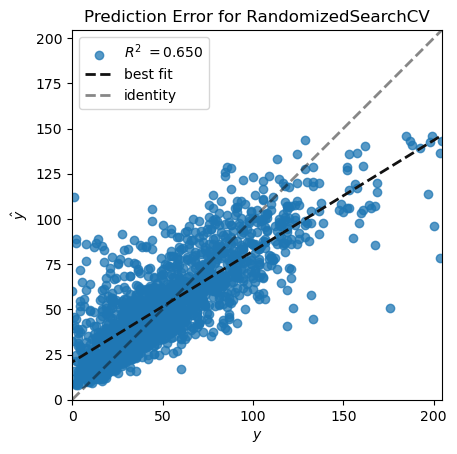

0.6497271401127793


In [160]:
# Plotting the prediction errors (Want 1:1)
visualizer = PredictionError(carbon_rf)
visualizer.score(model_data.get_x()[1],  model_data.get_y()[1])
visualizer.poof()
f_list = [model_data.get_x()[0].columns]
print(r2_score(model_data.get_y()[1], pred))

## Displaying Importance Values and Displaying the Graph with the Highest Value

Feature Importance:
Age2018       0.497148
NDMI_Jun13    0.257065
PRISM_tave    0.119271
PRISM_ppt     0.106481
NDVI_Jun13    0.020035
dtype: float64 

Feature with Highest Importance:  Age2018


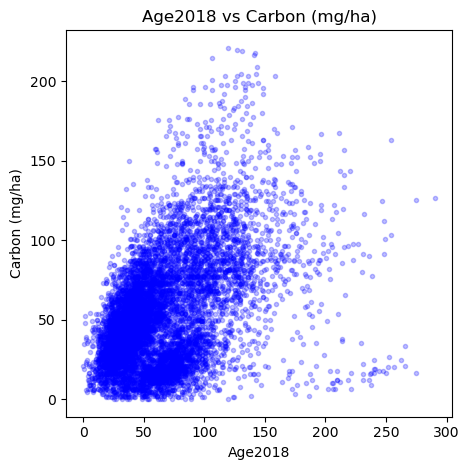

In [157]:
importance = pd.Series(
    carbon_rf.best_estimator_._final_estimator.feature_importances_,
    carbon_rf.best_estimator_.feature_names_in_,
).sort_values(ascending=False)
print('Feature Importance:')
print(importance, '\n')

# Displaying all the Data
print('Feature with Highest Importance: ', importance.index[0])
plot1 = plt.scatter(USFS_forest[importance.index[0]], USFS_forest['Carbon (mg/ha)'], label = 'Observed', color = 'blue', marker='.', alpha=0.25)
plt.gca().set_aspect(aspect=1/plt.gca().get_data_ratio()) # Setting the graph(s) to be a one to one ratio (square)
plt.ylabel('Carbon (mg/ha)')
plt.xlabel(importance.index[0])
plt.title(importance.index[0]+' vs Carbon (mg/ha)')
# plt.legend(handles=[plot1], loc='best',)
plt.tight_layout()
plt.show()

## Best Estimator Parameters

In [158]:
print('Best Estimator & Parameters:')
print('Score: ', round(r2_score(model_data.get_y()[1], pred), 3))
print(carbon_rf.best_params_, '\n')
print(results.loc[carbon_rf.best_index_])

Best Estimator & Parameters:
Score:  0.65
{'scale__n_quantiles': 644, 'model__n_estimators': 721, 'model__min_samples_split': 82, 'model__min_samples_leaf': 32, 'model__max_features': 105, 'model__max_depth': 1592} 

mean_fit_time                                                             12.198016
std_fit_time                                                                0.78722
mean_score_time                                                            0.055396
std_score_time                                                             0.004818
param_scale__n_quantiles                                                        644
param_model__n_estimators                                                       721
param_model__min_samples_split                                                   82
param_model__min_samples_leaf                                                    32
param_model__max_features                                                       105
param_model__max_depth     

## Saving the model (in binary) to a file 

In [159]:
with open('./savedModels/'+'model_'+'carbon'+'_'+str(round(r2_score(model_data.get_y()[1], pred), 4))+'.pkl', 'wb') as savefile: # Saving model to a file so that it could be recalled later
    pickle.dump(carbon_rf, savefile)

if not pathlib.Path('./savedModels/'+'model_'+'carbon'+'_param.txt').is_file(): # If file does not exist
    with open('./savedModels/'+'model_'+'carbon'+'_param.txt', 'w') as paramFile: # Create new file
        paramFile.write(str(time.ctime())+' - '+'model_'+'carbon'+str(round(r2_score(model_data.get_y()[1], pred), 4))+' '+str(carbon_rf.best_params_)+'\n\n')
else: # If the file already exists
    with open('./savedModels/'+'model_'+'carbon'+'_param.txt', 'a') as paramFile: # Append to file
        paramFile.write(str(time.ctime())+' - '+'model_'+'carbon'+str(round(r2_score(model_data.get_y()[1], pred), 4))+' '+str(carbon_rf.best_params_)+'\n\n')

print('Save completed!')

Save completed!
